In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch
from sklearn.preprocessing import StandardScaler

In [2]:
train_data = pd.read_pickle('/content/drive/MyDrive/choosen/train.pkl')
test_data = pd.read_pickle('/content/drive/MyDrive/choosen/test.pkl')

In [3]:
train_metadata = pd.read_csv("/content/drive/MyDrive/choosen/train_metadata.csv")
test_metadata = pd.read_csv("/content/drive/MyDrive/choosen/test_metadata.csv")

In [4]:
import cv2
import os
import pandas as pd
from tqdm import tqdm

# Assuming `balanced_df` contains the image names in the 'image' column
imgsTrainin = []
# Output directory for resized images

# Loop through the image names in balanced_df and process them
for image_name in tqdm(train_data['image']):
    # Construct the full image file path
    image_path = os.path.join("/content/drive/MyDrive/choosen/" + image_name + ".jpg")  # Adjust extension if needed

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image {image_name} not found or could not be read.")
        continue

    # Resize the image to 500x500
    resized_image = cv2.resize(image, (224, 224))
    imgsTrainin.append(resized_image)

    # Save the resized image to the output directory
    # output_path = os.path.join(output_directory, image_name + "_resized.jpg")
    # cv2.imwrite(output_path, resized_image)

# Assuming `balanced_df` contains the image names in the 'image' column
imgsTesting = []
# Output directory for resized images

# Loop through the image names in balanced_df and process them
for image_name in tqdm(test_data['image']):
    # Construct the full image file path
    image_path = os.path.join("/content/drive/MyDrive/choosen/" + image_name + ".jpg")  # Adjust extension if needed

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    if image is None:
        print(f"Image {image_name} not found or could not be read.")
        continue

    # Resize the image to 500x500
    resized_image = cv2.resize(image, (224, 224))
    imgsTesting.append(resized_image)

    # Save the resized image to the output directory
    # output_path = os.path.join(output_directory, image_name + "_resized.jpg")
    # cv2.imwrite(output_path, resized_image)

print("Image resizing completed.")

100%|██████████| 384/384 [00:05<00:00, 66.04it/s]

Image resizing completed.


In [5]:
labels_one_hot = train_data.iloc[:, 1:].values
labelstrain = [list(row).index(1.0) for row in labels_one_hot]
labels_one_hot = test_data.iloc[:, 1:].values
labelstest = [list(row).index(1.0) for row in labels_one_hot]

stacked_array = np.stack(labelstrain)  # Shape: (num_samples, 3, 500, 500)
torch_labels_train = torch.from_numpy(stacked_array)

stacked_array = np.stack(labelstest)  # Shape: (num_samples, 3, 500, 500)
torch_labels_test = torch.from_numpy(stacked_array)

stacked_array = np.stack(imgsTrainin)  # Shape: (num_samples, 3, 500, 500)
torch_images_train = torch.from_numpy(stacked_array).float()  # Ensure it's a float tensor

stacked_array = np.stack(imgsTesting)  # Shape: (num_samples, 3, 500, 500)
torch_images_test = torch.from_numpy(stacked_array).float()  # Ensure it's a float tensor

# Example data (replace with your actual tensors)
train_images = torch_images_train.permute(0, 3, 1, 2)
test_images = torch_images_test.permute(0, 3, 1, 2)
train_labels = torch_labels_train
test_labels = torch_labels_test

# Wrap into TensorDataset
train_dataset = TensorDataset(train_images, train_labels)
test_dataset = TensorDataset(test_images, test_labels)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
X_train = train_metadata.drop(columns=['image'])  # Remove 'image' column if not used for training
y_train = np.array(labelstrain)  # Assuming this is a list or array of labels

X_test = test_metadata.drop(columns=['image'])  # Remove 'image' column if not used for training
y_test = np.array(labelstest)  # Assuming this is a list or array of labels

# Normalize/Standardize the data (especially for age and anatomical site)
scaler = StandardScaler()
X_scaled_train = scaler.fit_transform(X_train)

scaler = StandardScaler()
X_scaled_test = scaler.fit_transform(X_test)

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# 1. Prepare the dataset combining images and metadata

# Assuming X_scaled_train and X_scaled_test are metadata (scaled),
# and train_images and test_images are your image tensors.

# Load metadata
X_train = torch.tensor(X_scaled_train, dtype=torch.float32)
X_val = torch.tensor(X_scaled_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_val = torch.tensor(y_test, dtype=torch.long)

# Combine image data and metadata into one dataset
class CombinedDataset(torch.utils.data.Dataset):
    def __init__(self, images, metadata, labels):
        self.images = images
        self.metadata = metadata
        self.labels = labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        meta = self.metadata[idx]
        label = self.labels[idx]
        return image, meta, label

train_dataset = CombinedDataset(train_images, X_train, y_train)
test_dataset = CombinedDataset(test_images, X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# 2. Define the hybrid model (CNN + FC)

class HybridCNNFCModel(nn.Module):
    def __init__(self, num_classes=8, metadata_dim=3, image_height=224, image_width=224):
        super(HybridCNNFCModel, self).__init__()

        # CNN layers for image feature extraction
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Compute the size of the feature map after passing through CNN layers
        with torch.no_grad():
            dummy_input = torch.zeros(1, 3, image_height, image_width)
            cnn_output = self._cnn_forward(dummy_input)
            flattened_size = cnn_output.view(1, -1).size(1)  # Flatten the output

        # Fully connected layers for classification
        self.fc1 = nn.Linear(flattened_size + metadata_dim, 128)  # Input is CNN output + metadata
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)
        self.relu = nn.ReLU()

    def _cnn_forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the output
        return x

    def forward(self, image, metadata):
        # CNN part for image feature extraction
        x = self._cnn_forward(image)

        # Concatenate CNN features with metadata
        x = torch.cat((x, metadata), dim=1)

        # Fully connected layers for classification
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3(x)  # Output layer without softmax
        return x  # No softmax here, as CrossEntropyLoss handles it internally



# 3. Initialize the model, loss function, and optimizer

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridCNNFCModel(num_classes=8, metadata_dim=X_train.shape[1]).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# 4. Training and testing loop

num_epochs = 40
trainingHolder = []
testingHolder = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_preds = 0
    total_preds = 0

    for images, metadata, labels in train_loader:
        images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)

        # Forward pass
        outputs = model(images, metadata)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct_preds += (predicted == labels).sum().item()
        total_preds += labels.size(0)

    avg_loss = running_loss / len(train_loader)
    accuracy = (correct_preds / total_preds) * 100
    trainingHolder.append(accuracy)

    # Validation loop
    model.eval()
    correct_preds = 0
    total_preds = 0
    with torch.no_grad():
        for images, metadata, labels in test_loader:
            images, metadata, labels = images.to(device), metadata.to(device), labels.to(device)
            outputs = model(images, metadata)
            _, predicted = torch.max(outputs, 1)
            correct_preds += (predicted == labels).sum().item()
            total_preds += labels.size(0)

    accuracy = (correct_preds / total_preds) * 100
    testingHolder.append(accuracy)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Training Accuracy: {accuracy:.2f}%")



Epoch [1/40], Loss: 6.7299, Training Accuracy: 18.49%
Epoch [2/40], Loss: 1.9345, Training Accuracy: 27.08%
Epoch [3/40], Loss: 1.7514, Training Accuracy: 31.25%
Epoch [4/40], Loss: 1.5775, Training Accuracy: 34.64%
Epoch [5/40], Loss: 1.4114, Training Accuracy: 36.46%
Epoch [6/40], Loss: 1.1812, Training Accuracy: 34.64%
Epoch [7/40], Loss: 0.9891, Training Accuracy: 39.32%
Epoch [8/40], Loss: 0.7994, Training Accuracy: 35.42%
Epoch [9/40], Loss: 0.7068, Training Accuracy: 38.02%
Epoch [10/40], Loss: 0.5329, Training Accuracy: 38.54%
Epoch [11/40], Loss: 0.4214, Training Accuracy: 34.38%
Epoch [12/40], Loss: 0.3450, Training Accuracy: 33.33%
Epoch [13/40], Loss: 0.2666, Training Accuracy: 40.62%
Epoch [14/40], Loss: 0.2180, Training Accuracy: 35.16%
Epoch [15/40], Loss: 0.1549, Training Accuracy: 37.24%
Epoch [16/40], Loss: 0.1530, Training Accuracy: 35.68%
Epoch [17/40], Loss: 0.0864, Training Accuracy: 39.32%
Epoch [18/40], Loss: 0.0569, Training Accuracy: 36.46%
Epoch [19/40], Loss

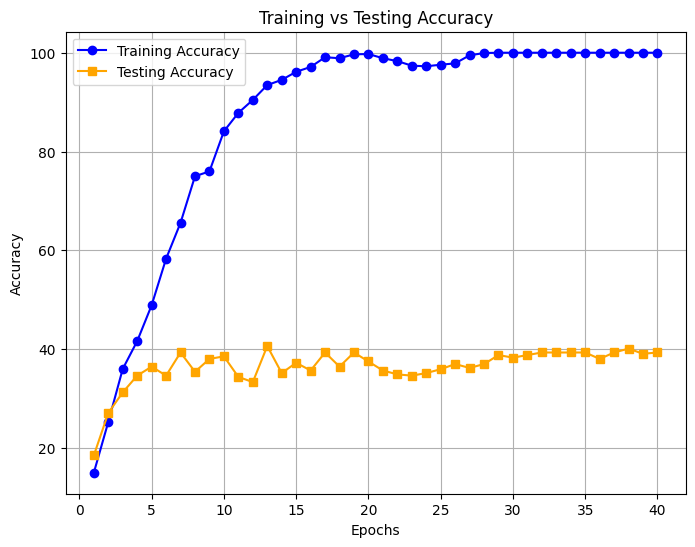

In [8]:
epochs = range(1, len(trainingHolder) + 1)

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, trainingHolder, label='Training Accuracy', marker='o', color='blue')
plt.plot(epochs, testingHolder, label='Testing Accuracy', marker='s', color='orange')

# Add labels, title, and legend
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Testing Accuracy')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [9]:
max(testingHolder)

40.625